# Deep Drilling Field observing strategy

In [1]:
# Import required python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
import astropy.units as u
import rubin_scheduler.scheduler.utils as sched_utils
from rubin_scheduler.utils import ddf_locations
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf

In [2]:
summaries = maf.get_metric_summaries(summary_source='summary.h5')
print(f"This summary h5 file contains information on {len(summaries.index)} simulations.")
baselinerun = 'baseline_v3.4_10yrs'
ddf_accor = [r for r in summaries.index if r.startswith('ddf_acor')]
ddf_loaded = [r for r in summaries.index if r.startswith('ddf_loaded') and 'half' not in r]
# hack a rearrangement for ddf_loaded
ddf_loaded = ddf_loaded[1:] + ddf_loaded[0:1]
ddf_half = [r for r in summaries.index if r.startswith('ddf') and 'half' in r]
# hack a rearrangement for ddf_half
tmp = ddf_half[0:1] + ddf_half[2:] + ddf_half[1:2]
ddf_half = tmp
all_runs = [baselinerun] + ddf_accor + ddf_loaded + ddf_half
print(f"There are {len(ddf_accor) + len(ddf_loaded) + len(ddf_half)} specific DDF experiments.")

This summary h5 file contains information on 254 simulations.
There are 48 specific DDF experiments.


In [3]:
metric_subsets = maf.get_metric_subsets(metric_subset_source='metric_subsets.json')
msets = list(metric_subsets.groupby('metric subset').first().index)
# DDF specific metrics
[m for m in msets if 'DDF' in m]

['AGN SF DDF',
 'AGN TimeLag 100 days DDF',
 'AGN TimeLag 5 days DDF',
 'DDF Cadence',
 'DDF Depths',
 'SNIa DDF',
 'SNSL DDF']

### Deep drilling field observing strategy

A series of DDF survey strategies have been explored in the v3.4 simulations. The opsim databases can be downloaded from:
https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/ <br>
and their corresponding configuration scripts can be found at https://github.com/lsst-sims/sims_featureScheduler_runs3.4

The detailed MAF metrics for each simulation are available here - http://astro-lsst-01.astro.washington.edu:8080 - with particular emphasis on the "DD metrics". (see for example the [baseline DD metrics](http://astro-lsst-01.astro.washington.edu:8080/allMetricResults?runId=2)). 

In particular, the simulations under `ddf_accor`, `ddf_loaded`, and `ddf_loaded_half` hold the relevant variations on the DDF survey strategy. 

The baseline survey strategy for the DDFs includes 5 DDF pointings, with varying number of visits per DDF:
* COSMOS attains 10 year DDF depth by year 3, and continues observations thus acquiring almost double the other pointings.
* Euclid Deep Field South (EDFS) is split into two different pointings (a, b) to match the Euclid field size, but share the total number of visits.
* A rough baseline number is that each DDF obtains about 21,000 visits over 10 years, corresponding to about 6% of the total (2.1M) visits.

In [4]:
# Basic DDF information, number of visits from baseline simulation
ddfs = ddf_locations()
conn = sqlite3.connect('baseline_v3.4_10yrs.db')
pdfs = {}
for i in ddfs:
    ra = ddfs[i][0]
    dec = ddfs[i][1]
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    eclip_lat = coord.barycentrictrueecliptic.lat.deg
    eclip_lon = coord.barycentrictrueecliptic.lon.deg
    gal_lon = coord.galactic.l.deg
    gal_lat = coord.galactic.b.deg
    query = f"select count(*) from observations where note like 'DD:{i.upper()}'";
    nvis_ddf = int(pd.read_sql(query, conn).values[0][0])
    pdfs[i] = [ra, dec, gal_lon, gal_lat, eclip_lon, eclip_lat, nvis_ddf]
d = pd.DataFrame(pdfs, index=['RA', 'Dec', 'Gal l', 'Gal b', 'Eclip l', 'Eclip b', 'Nvisits']).round(2)
d

ELAISS1   XMM_LSS     ECDFS    COSMOS    EDFS_a    EDFS_b
RA           9.45     35.71     53.12    150.10     58.90     63.60
Dec        -44.00     -4.75    -28.10      2.18    -49.32    -47.60
Gal l      311.30    171.21    224.07    236.83    257.89    254.48
Gal b      -72.91    -58.77    -54.47     42.09    -48.46    -45.77
Eclip l    346.68     31.74     40.99    151.40     32.01     40.97
Eclip b    -43.18    -17.90    -45.47     -9.39    -66.60    -66.60
Nvisits  20768.00  22222.00  22217.00  42240.00  11518.00  11483.00

In the baseline simulation, visits are acquired in sequences where a DDF is observed continuously in grizy or ugriz filters for approximately one hour. Complete sequences consist of 
* 8 u band visits (if u is available)
* 10 g band visits
* 20 r band visits
* 20 i band visits
* 24 z band visits
* 18 y band visits (if y is available)
Each visit is 30 seconds of on-sky exposure time; u band visits are 1x30s while other bandpasses are 2x15s.

In the `ddf_accor` simulations, the sequences are as above, but the overall season length and pacing within the season is varied. There is a "high" and "low" portion of each season, where the rate of acquiring sequences increases or decreases.

In the `ddf_loaded` and `ddf_loaded_half` simulations, sequences are split apart. Taking advantage of the fast slewtime for Simonyi telescope, these simulations explore the effect of slewing to the DDF when the filter is already in use (as the slewtime is generally faster than the filter change time). The resulting observations of each DDF include the same number of visits per filter as above (in `ddf_loaded`), but do not observe continuously in all available filters for an hour. 

In the various `half` simulations (`ddf_loaded_half` and `ddf_half`) the number of visits per filter in each sequence is cut in half. This should result in a shorter time between sequences, but less depth in a given sequence.

# Fraction of DDF time

Varying the DDF strategy can inadvertently change the overall number of DDF visits or the overall fraction of survey time devoted to DDF observations. Changes here can affect the overall metrics for the strategy, so is worth checking first to identify which runs could be considered the most "apples to apples". 

(0.033, 0.072)

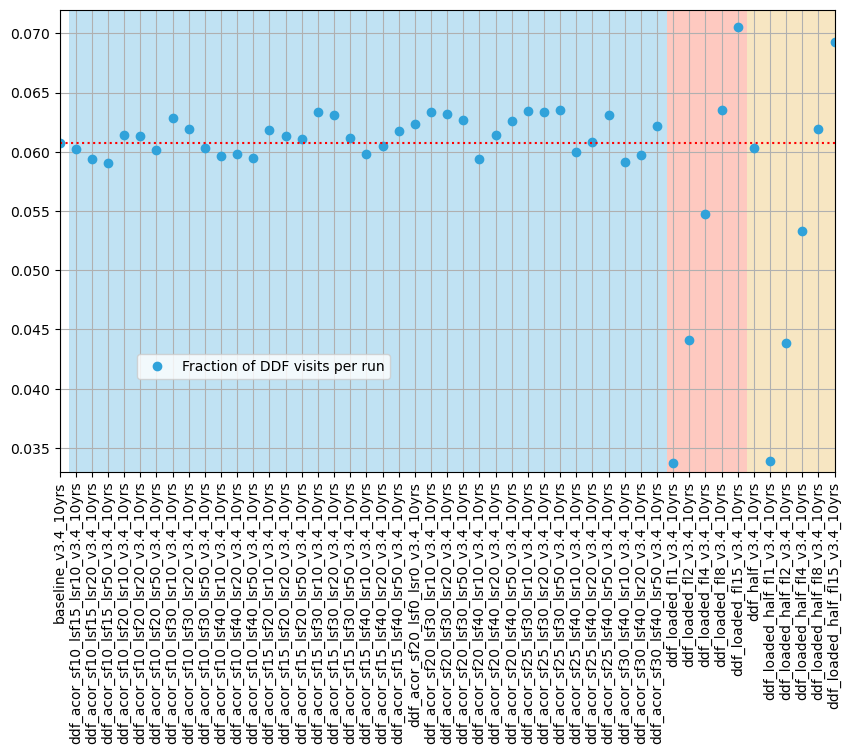

In [5]:
visits = ['Identity Nvisits All visits UniSlicer', 'Identity Nvisits DDF UniSlicer']
fraction = pd.DataFrame(summaries.loc[all_runs, visits[1]] / summaries.loc[all_runs, visits[0]],
                       columns=["Fraction of DDF visits per run"])

fig, ax = maf.plot_run_metric(fraction, shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(0.1, 0.2))
ax.axhline(fraction.loc[baselinerun].values, color='red', linestyle=':')
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.01), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(0.033, 0.072)

The plot of fraction of DDF visits in each simulation shows that most of the simulations vary slightly around the 6% achieved in the baseline simulation, but there are some notable exceptions in the "loaded" families of simulations.

The `ddf_loaded` simulations "work" by requesting a sequence of visits in all filters, then only acquiring those visits when the filter is already in use. The request comes with a "flush by" time -- if the visits are not acquired by this flush by time, then the request is dropped. The length of time before the "flush by" date is varied in these simulations and indicated by the `fl` value in the name of the simulation. The `ddf_loaded_half` simulations work similarly, but instead of requesting say 10 or 20 visits per sequence, only requests 5 or 10 visits. We can see that the flush by date affects the overall number of visits, and flush by times of less than 4 days are not likely to be good candidates while flush by times of 15 days spend close to the upper limit of visits in the DDFs.

We can also double check on the end of survey coadded depths for each DDF in each filter -- in general, we'd expect them to track with the trends above: 

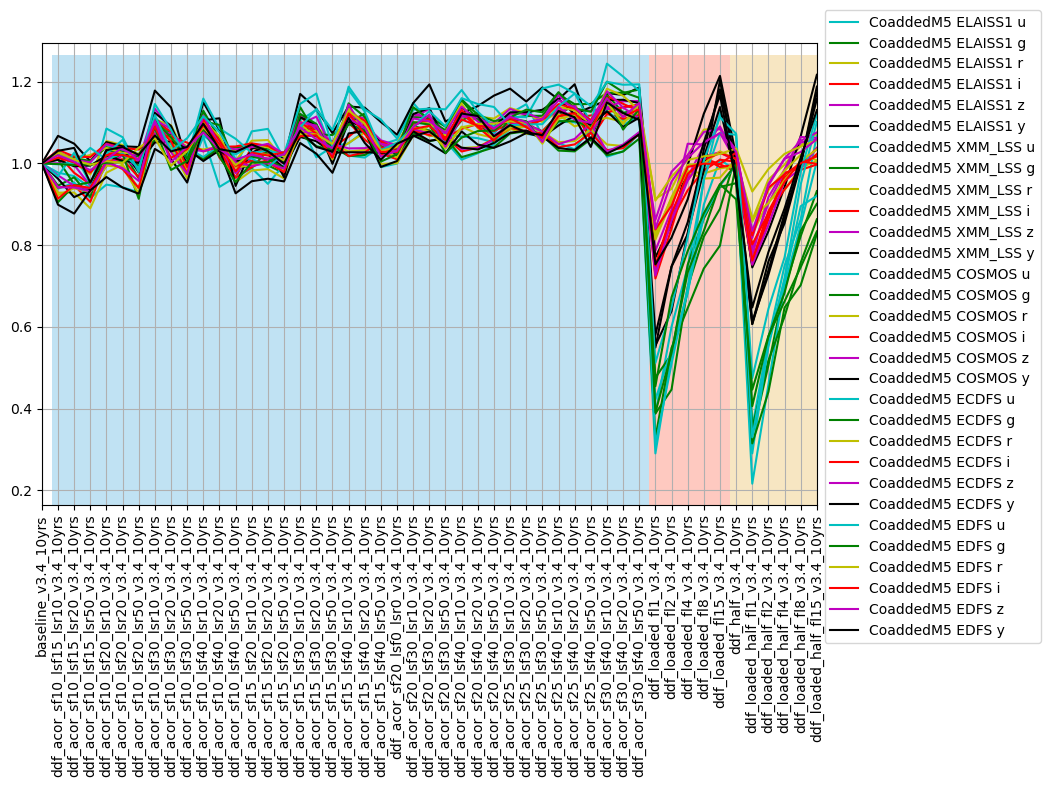

In [6]:
msub = metric_subsets.loc['DDF Depths'].query("not metric.str.contains('WFD') and metric.str.contains('Coadd')")
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, -0.3))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

We don't see a perfect track with the fraction of visits in the DDFs -- the accordian simulations with shorter seasons go deeper than you'd expect from the same fraction of visits (likely due to acquiring these visits at better airmass when away from the ends of the season) -- but the "loaded" simulations are shallower when they don't acquire as many visits. 

The `ddf_accor` simulations vary the rate of acquisition of visits throughout the DDF season. "sf" is inversely related to the overall season length (season fraction represents the amount of time *removed* from the possible s) and "lsf" represents the fraction of that season during which visits are acquired at a low rate ("lsr" specifies the rate). A simulation with smaller "sf" value has a longer overall season, and a simulation with a smaller "lsf" value has a longer low-season fraction. 

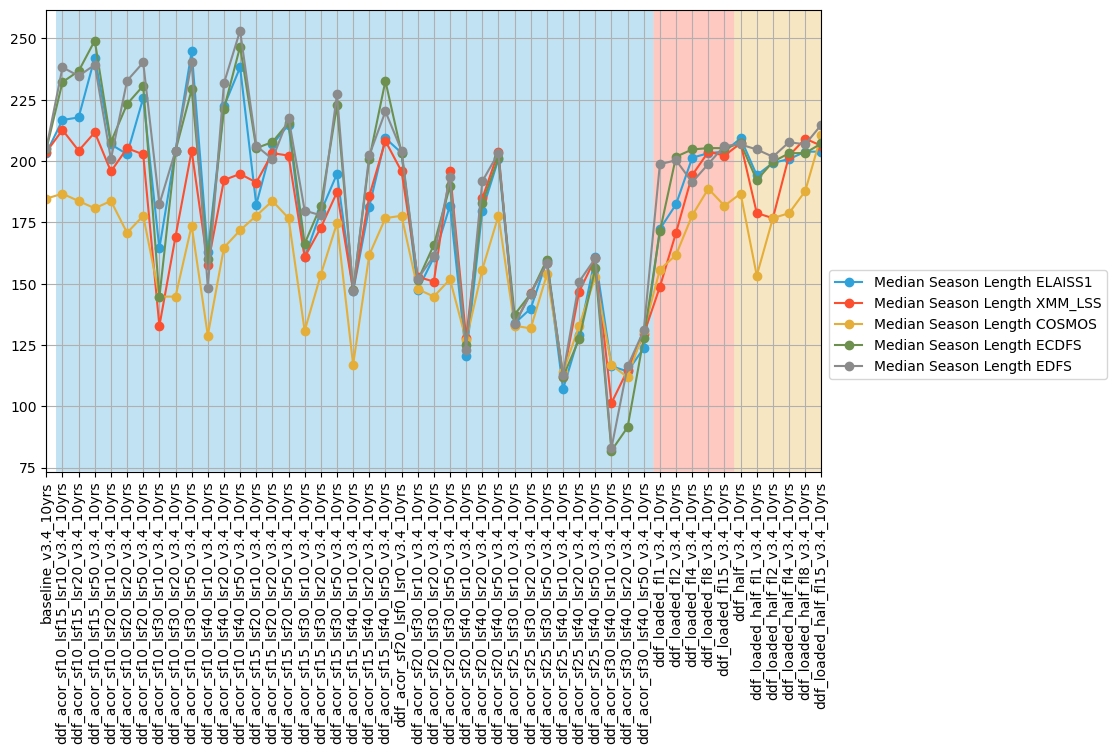

In [7]:
# Median season length (across all seasons)
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Season Length") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

Looking at the plot of median season length per DDF (median over all seasons) we see that the baseline simulation has typical season lengths of about 200/210 days, which is roughly consistent with the season lengths for the "loaded" families. The accordian family shows clear variation in season length, as was intended; a "sf" value of 10 results in longer seasons, while larger values start to reduce the season length, becoming noticable at around sf=20. 

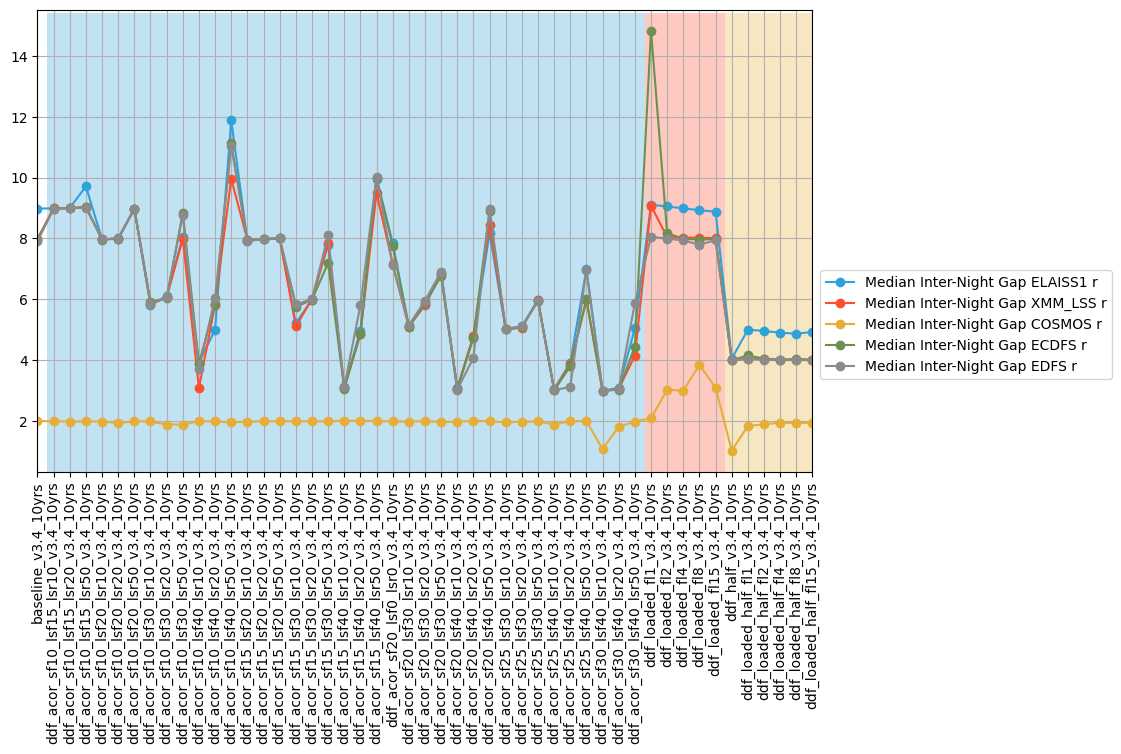

In [8]:
# Median inter-night gap in r band; i and z band similar trends
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap r") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

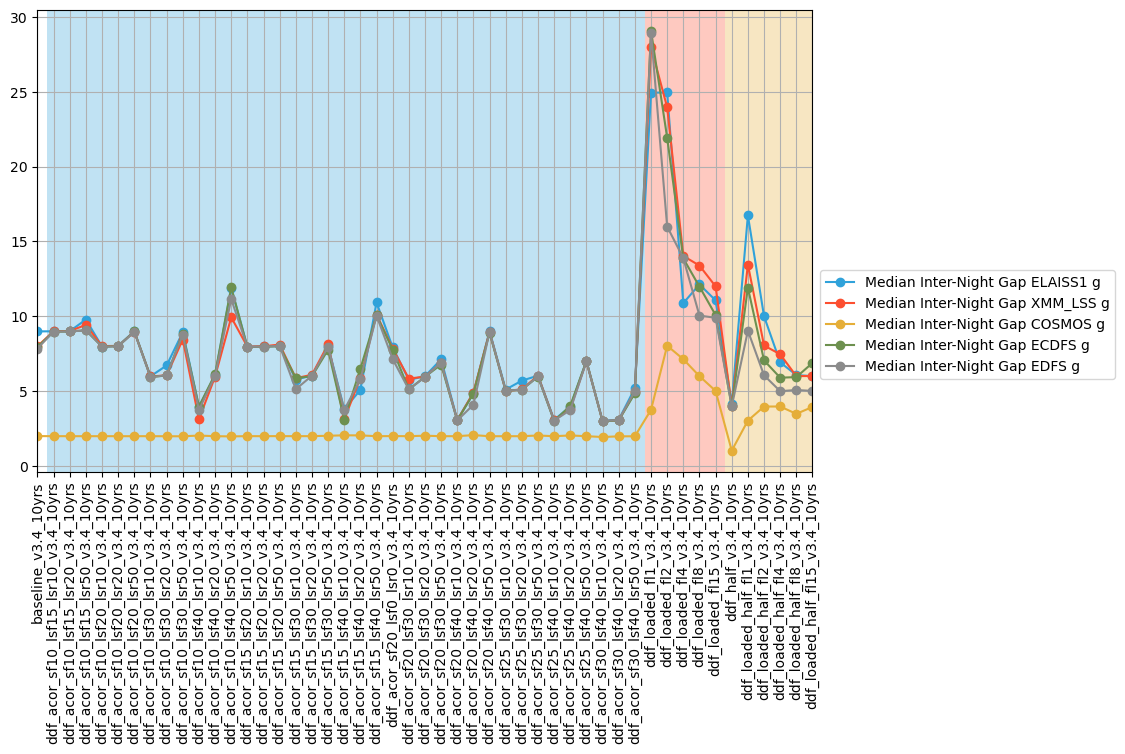

In [9]:
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap g") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

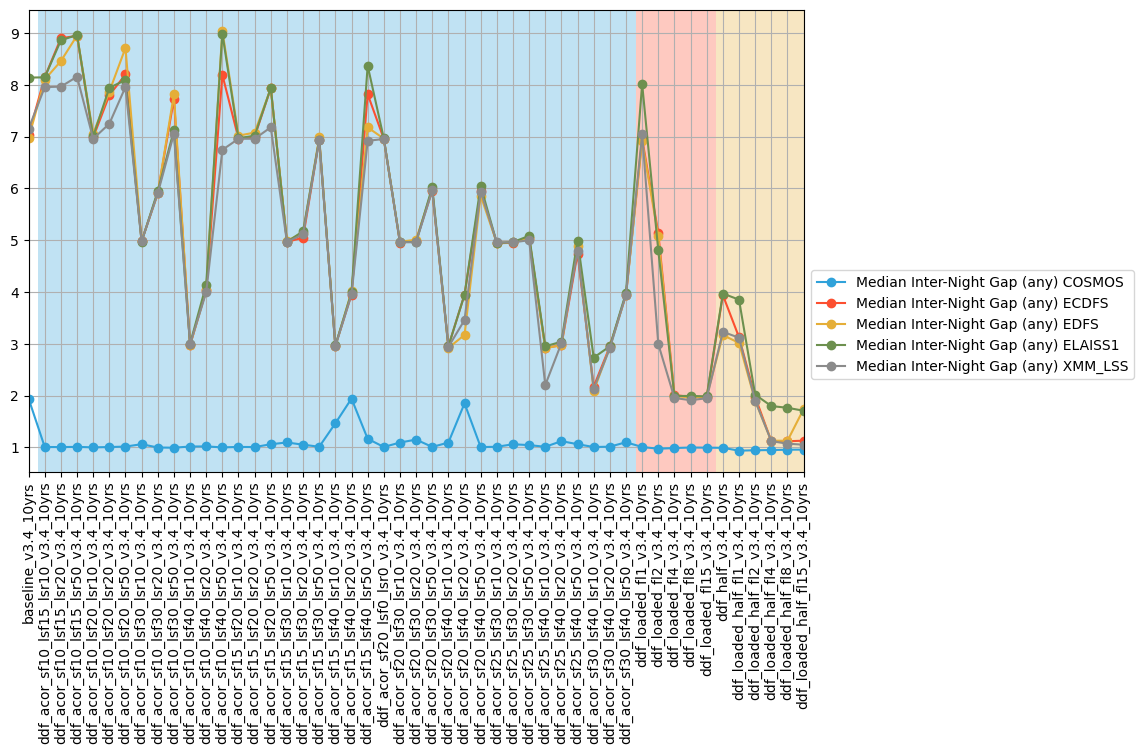

In [10]:
metric = [m for m in summaries if 'DD:' in m and 'Median Inter-Night Gap all bands' in m and 'WFD' not in m]
short_names = [f"Median Inter-Night Gap (any) {m.split('DD:')[1].split(' ')[0]}" for m in metric]
mapper = dict(zip(metric, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metric],
                              #metric_subset=msub,
                              metric_label_map=mapper,
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

The season length and number of visits are the primary levers on the median inter-night gap, although variations in the accordian families can also vary the gap -- especially when there is a very low low-season-rate ("lsr") with a large low-season-fraction ("lsf"), which concentrates visits into a highly active period in the center of the season. 

The COSMOS field tends to have very good inter-night gap values, because of the first three years with a large number of visits. 
The `ddf_loaded` simulations have inter-night gaps in any given filter similar to the baseline, despite splitting the sequences; when considering visits in any filter, the gaps are shorter than the baseline. The `ddf_loaded_half` series shows the effect of splitting the sequences in half as well, which results in them being scheduled more often -- reducing the inter-night gap. Because there are fewer g band visits in the WFD and they occur in a more limited span of time (around new moon), it seems the effect of only scheduling DDF visits when g band is already in use disrupts the g band DDF scheduling more than some other bands such as r band (u band would have already had this disruption in the baseline, as the filter is entirely removed from the telescope). 

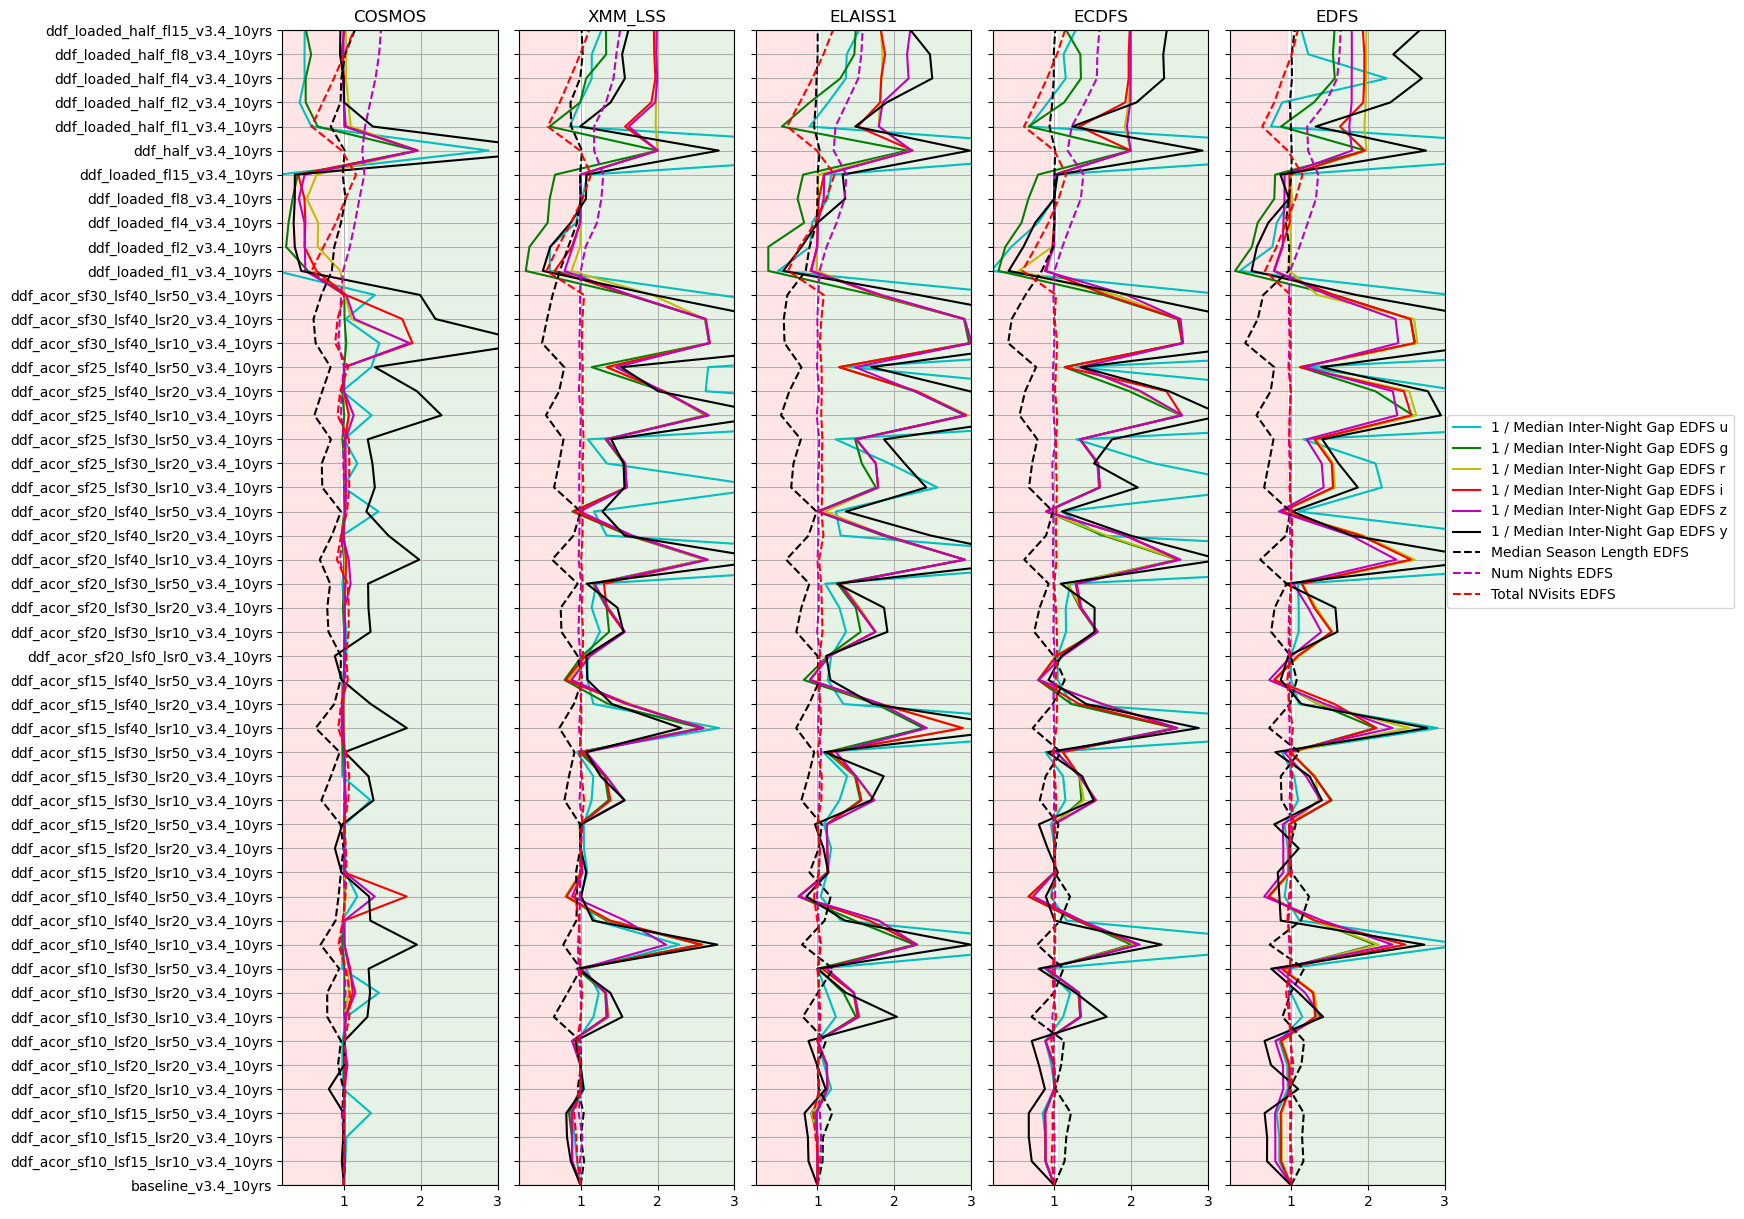

In [11]:
# Viewing this in a different way 
msub = metric_subsets.loc['DDF Cadence']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 3)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

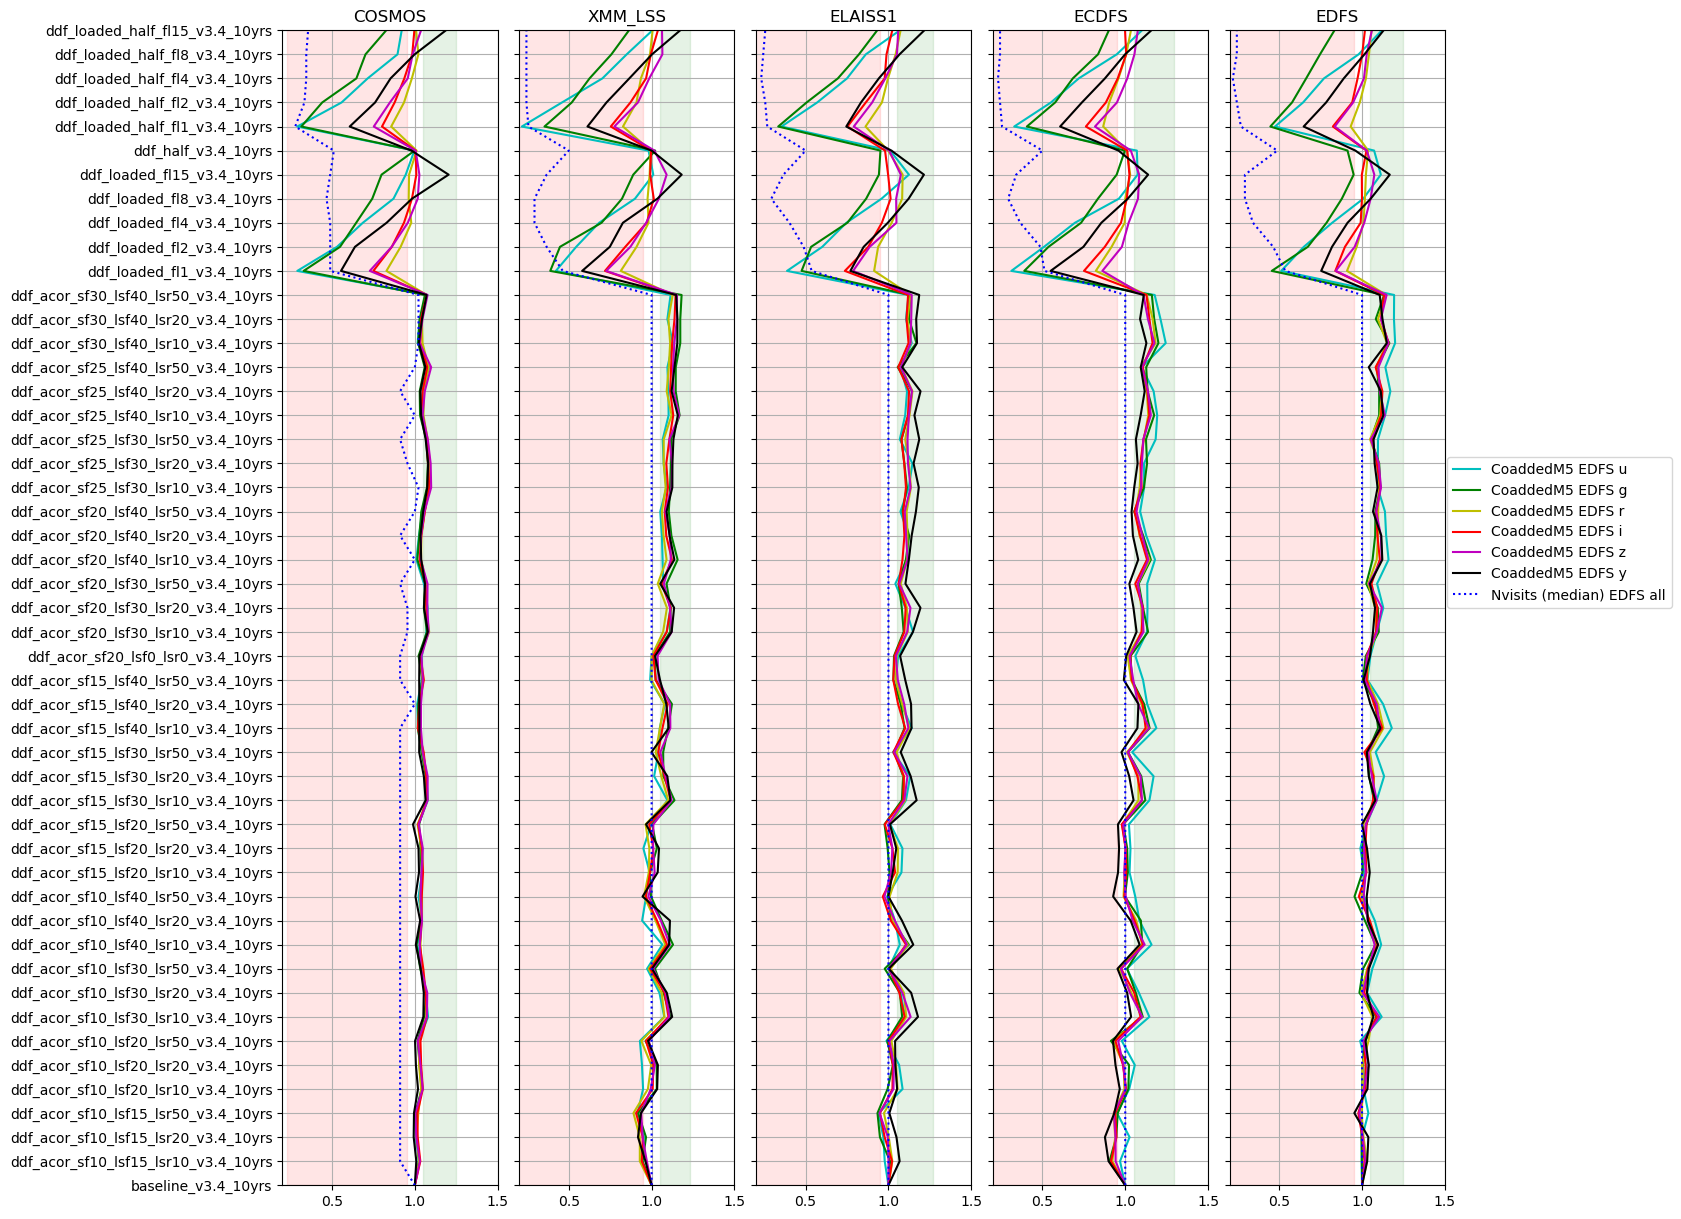

In [12]:
msub = metric_subsets.loc['DDF Depths']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

With some insights into what's happening in the DDFs with these variations in survey strategy, let's look at the metrics more oriented toward science and see how they respond.

## AGN metrics 

Text(0.5, 1.0, 'AGN SF Error combined (2*u+g+r)')

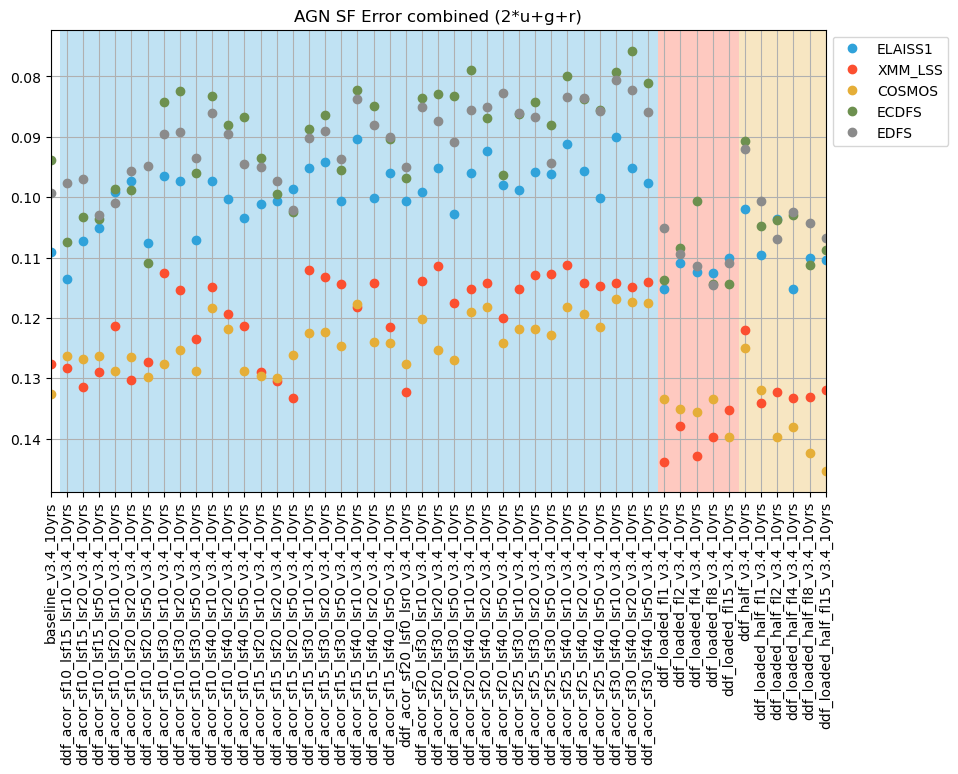

In [13]:
msub = metric_subsets.loc['AGN SF DDF'].query('not metric.str.contains("WFD")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
agn_sf = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(agn_sf, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
xi = 0.6
ylim = ax.set_ylim()
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.2, 0.01), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN SF Error combined (2*u+g+r)")

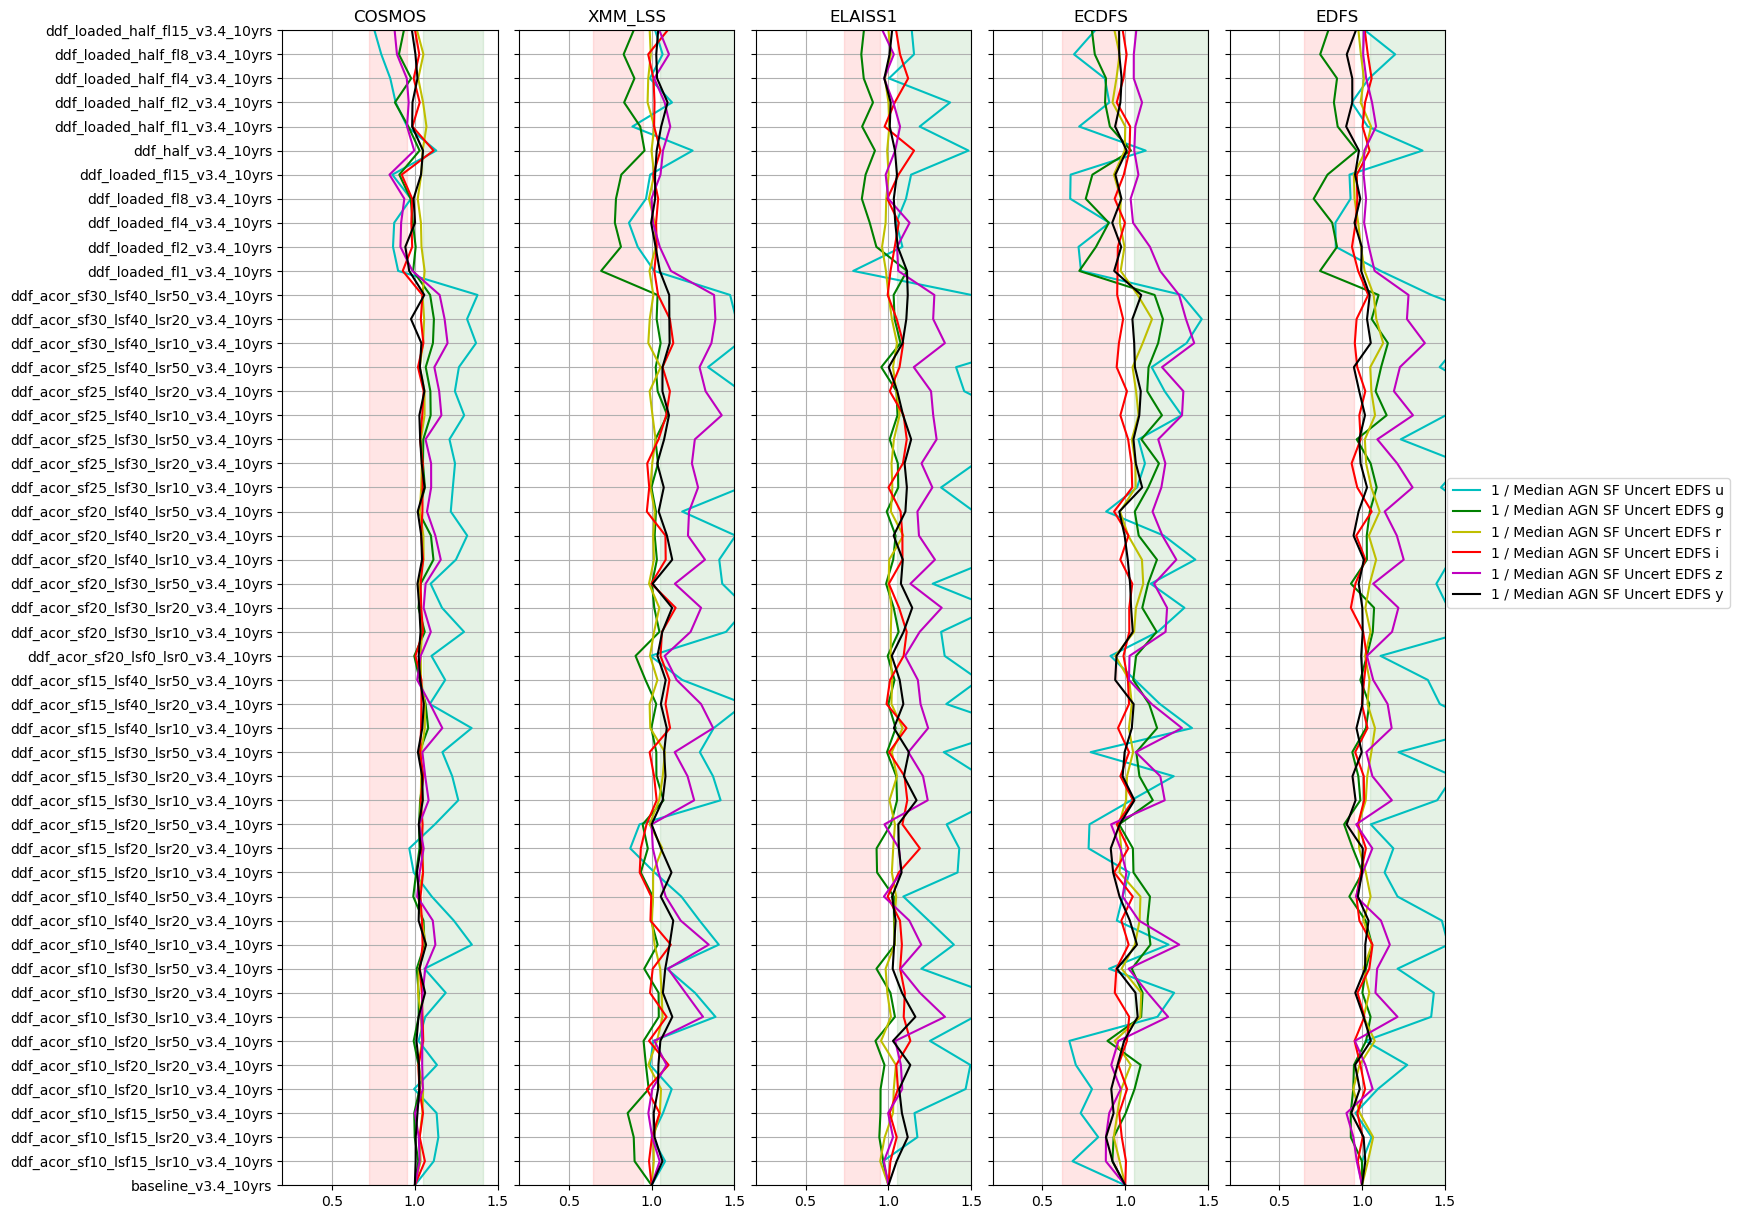

In [14]:
msub = metric_subsets.loc['AGN SF DDF']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

In [15]:
msub = metric_subsets.loc['AGN TimeLag 100 days DDF'].query('not metric.str.contains("WFD") and not metric.str.contains("all bands")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
values = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
xi = 0.6
ylim = ax.set_ylim()
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.2, 0.01), xi, xii, alpha=0.3)
    xi = xii
# ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 100 days combined (2*u+g+r)")

Text(0.5, 1.0, 'AGN Timelags 100 days combined (2*u+g+r)')

Text(0.5, 1.0, 'AGN Timelags 5 days all bands')

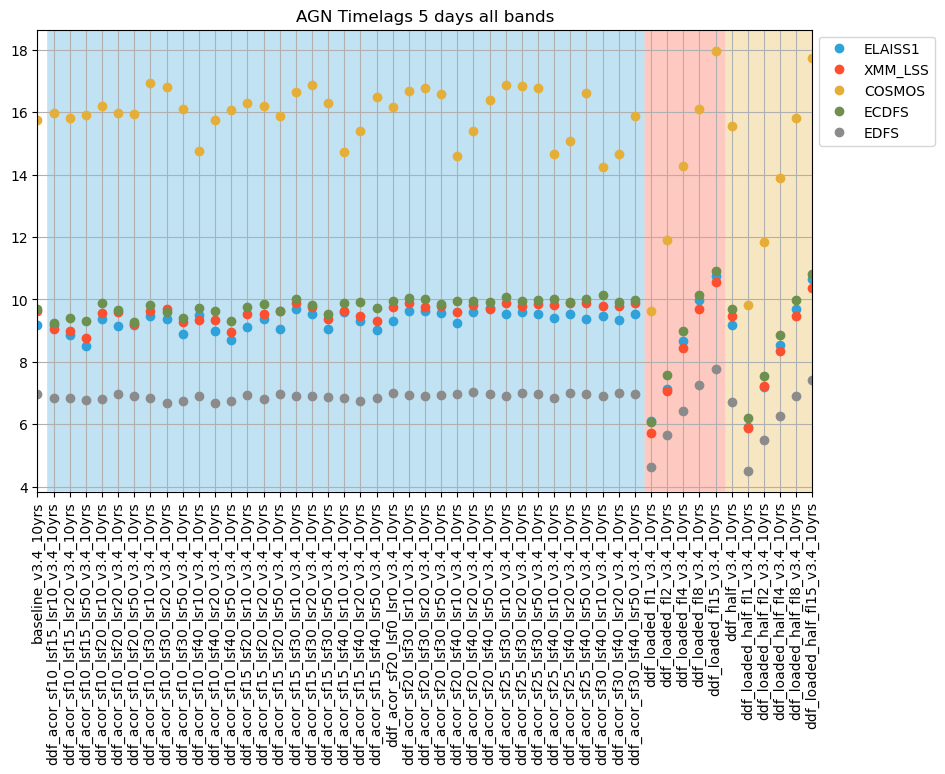

In [16]:
msub = metric_subsets.loc['AGN TimeLag 5 days DDF'].query('not metric.str.contains("WFD") and metric.str.contains("all bands")')

ddf_names = [i.split("DD:")[1].split(' ')[0] for i in msub['metric']]
values = pd.DataFrame(summaries.loc[all_runs, msub['metric']].values,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
xi = 0.6
ylim = ax.set_ylim()
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.2, 0.01), xi, xii, alpha=0.3)
    xi = xii
# ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 5 days all bands")

#### AGN summary:
The AGN Structure Function Error metric and the AGN 100-day and 5-day Time Lags (both plotted here so that "up" is "better") both show that flush by times less than 4 days are not good for the "loaded" simulations. "fl4", "fl8", and "fl15" are as good as or better than baseline, in either "loaded" or "half" configuration. The 5-day Time Lags could not be calculated as a combination of u, g, and r band values: the u and g band 5-day time lag summary values were often Nans. 
The SF Error metric shows worse results with any of the "loaded" simulations, which is likely due to the timing of g band visits in this strategy.

The AGN SF Error metric shows more variation across the accordian cadences, preferring more strongly "accordioned" cadences with shorter seasons.

### SNIa metrics 

The SNIa metrics run here with an nside of 128, which is significantly higher resolution than we use for evaluating the main survey. 

In [17]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], 0.1), xi, xii, alpha=0.3)
    xi = xii

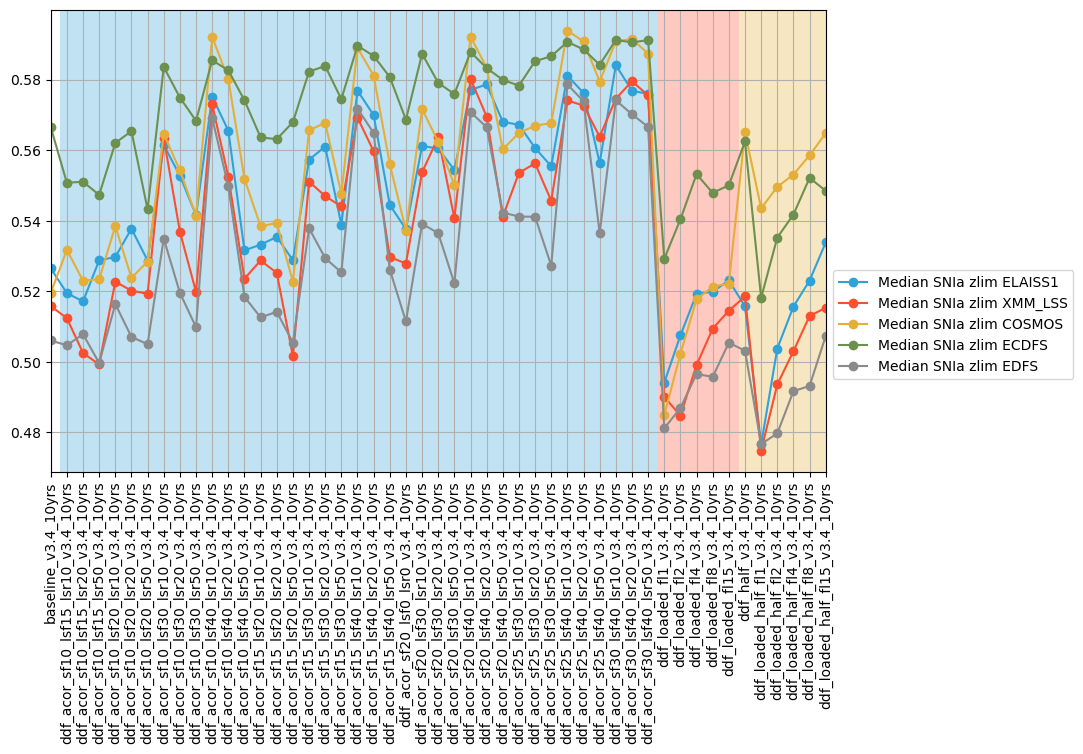

In [18]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

In [19]:
msub1 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
msub2 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
total_sn = summaries.loc[all_runs, msub1['metric']].sum(axis=1)
median_zlim = summaries.loc[all_runs, msub2['metric']].median(axis=1)

for fam, label in zip([[baselinerun], ddf_accor, ddf_loaded, ddf_half], ['baseline', 'accor', 'loaded', 'loaded half']):
    plt.plot(total_sn.loc[fam], median_zlim.loc[fam], marker='.', linestyle='', label=label)
plt.legend()

#### SNIa summary

With the metric we're running here, we find more SNIa with the "loaded" series of simulations, primarily because the SNIa metric does not require observations in different filters on the same night - and by splitting observations in different filters onto different nights (as we see below in the "number of unique nights"), then there are more epochs for each SN and more opportunities to discover and classify the SN. However, the redshift limit for completeness also drops with this technique.

Within the accordian series, there is some optimization possible regarding number of SNia and their redshift completeness; in general shorter seasons are preferable for reaching higher redshift, but a middle of the road season length is better for discovering more SNIa. 


In [20]:
msub = metric_subsets.loc['DDF Cadence'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("N Unique")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

## SLSN

Strongly lensed SN

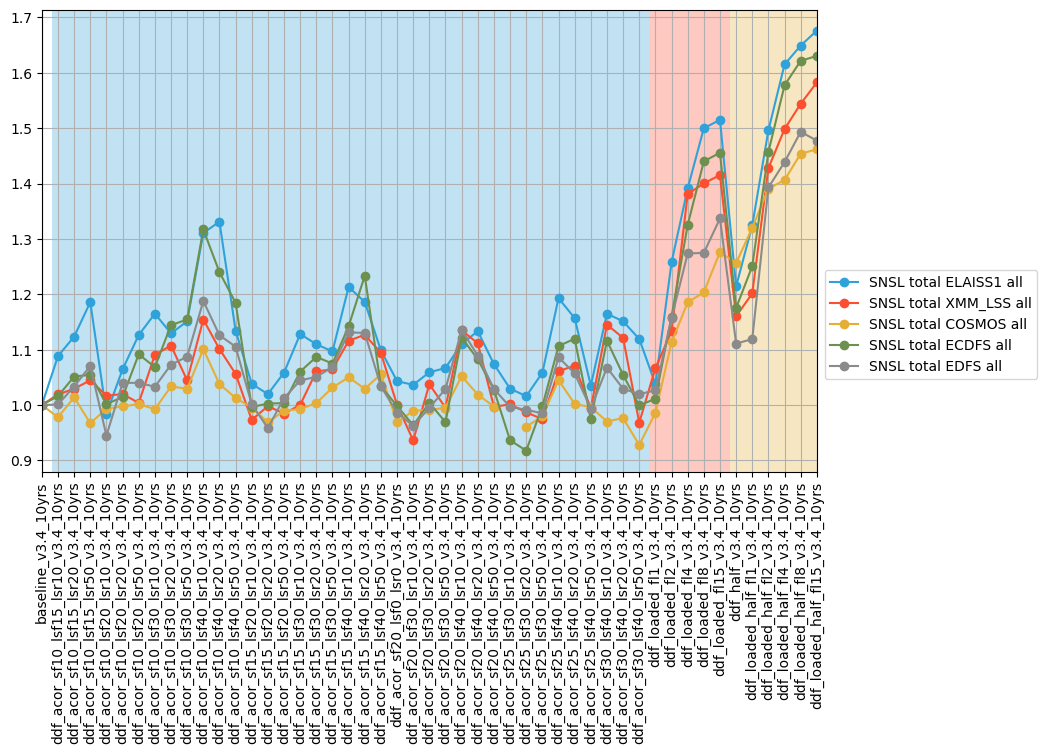

In [21]:
msub = metric_subsets.loc['SNSL DDF'].query('not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

One of the big drivers for discovering strongly lensed supernova is having lots of opportunities to discover these rare events. Having more unique nights with observations works in favor of this metric. 

## KNe metrics

In [22]:
metrics = [m for m in summaries if 'KNe' in m and 'ztfrest_simple ' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (TVS) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

In [23]:
metrics = [m for m in summaries if 'KNe' in m  and 'multi_color_detect' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (DESC) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

### Weak Lensing nvisits

The weak lensing metric counts exposure time in gri or riz bands.

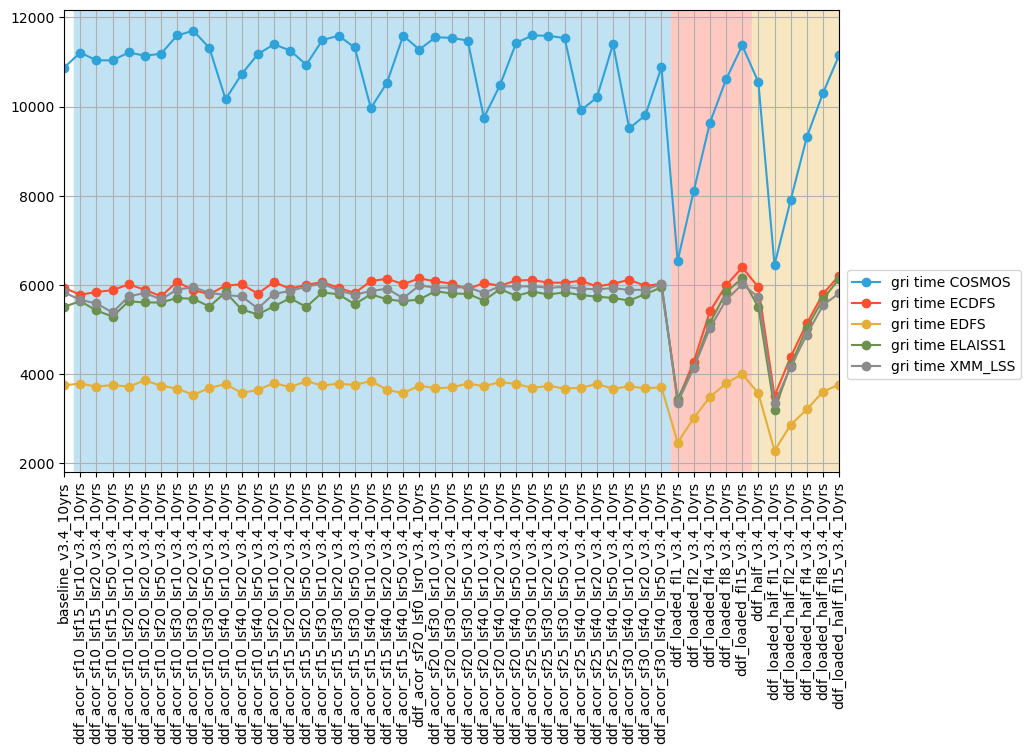

In [24]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'gri' in m]
short_names = [f"gri time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii

In [25]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'riz' in m]
short_names = [f"riz time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in [ddf_accor, ddf_loaded, ddf_half]:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1]+0.15, 0.1), xi, xii, alpha=0.3)
    xi = xii